In [7]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# from keras.utils import load_img, array_to_img, img_to_array
from keras.utils import *
from tensorflow.keras.optimizers import Adam
import random
import os
from tqdm.notebook import tqdm

import re

%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [20]:
img_size = 256

In [24]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [25]:
framObjTrain = LoadData( framObjTrain, imgPath = './data Set/CamVid/train', maskPath = './data Set/CamVid/train_labels'
         , shape = 256)

framObjValidation  = LoadData( framObjValidation, imgPath = './data Set/CamVid/val', maskPath = './data Set/CamVid/val_labels'
         , shape = 256)

In [26]:
print('Training Data Size : ', len(framObjTrain['img']))
print('Validation Data Size : ', len(framObjValidation['img']))

Training Data Size :  369
Validation Data Size :  100


In [46]:
print(np.array(framObjTrain['img']).shape)
print(np.array(framObjTrain['mask']).shape)
print(np.array(framObjValidation['img']).shape)
print(np.array(framObjValidation['mask']).shape)

(369, 256, 256, 3)
(369, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


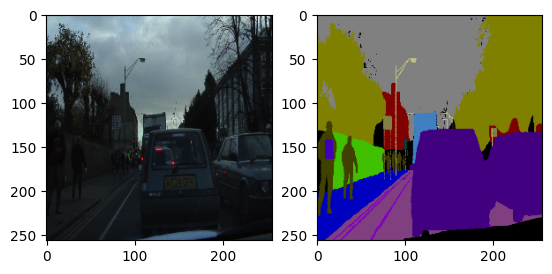

In [34]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [58]:
def conv_block(shape, out_ch, rate=1):
    x = tf.keras.layers.Conv2D(out_ch, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def RSU_L(shape, out_ch, M_ch, num_layers, rate=2):
    x = conv_block(shape, out_ch)
    inp_ch = x

    skip_features = []
    x = conv_block(x, M_ch)
    skip_features.append(x)

    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = conv_block(x, M_ch)
        skip_features.append(x)
        
    x = conv_block(x, M_ch, rate=rate)
    skip_features.reverse()
    x = tf.keras.layers.Concatenate()([x, skip_features[0]])
    x = conv_block(x, M_ch)

    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, skip_features[i+1]])
        x = conv_block(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, skip_features[-1]])
    x = conv_block(x, out_ch)

    x = tf.keras.layers.Add()([x, inp_ch])
    return x

def RSU_4F(shape, out_ch, M_ch):
    x0 = conv_block(shape, out_ch, rate=1)

    x1 = conv_block(x0, M_ch, rate=1)
    x2 = conv_block(x1, M_ch, rate=2)
    x3 = conv_block(x2, M_ch, rate=4)

    x4 = conv_block(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = conv_block(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = conv_block(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x

def u2net(shape, out_ch, M_ch, num_classes=1):
    inputs = tf.keras.layers.Input(shape)

    e1 = RSU_L(inputs, out_ch[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, out_ch[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, out_ch[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, out_ch[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, out_ch[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    b1 = RSU_4F(p5, out_ch[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, out_ch[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, out_ch[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, out_ch[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, out_ch[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, out_ch[10], M_ch[10], 7)

    
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    model = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return model

def build_u2net(input_shape, num_classes=3):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, M_ch, num_classes=num_classes)
    return model

u2net_model = build_u2net((img_size, img_size, 3))
u2net_model.summary()

Model: "U2-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_595 (Conv2D)             (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_560 (BatchN (None, 256, 256, 64) 256         conv2d_595[0][0]                 
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 256, 256, 64) 0           batch_normalization_560[0][0]    
_____________________________________________________________________________________________

In [59]:
opt = Adam(learning_rate=1e-3)
u2net_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('full_body.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [61]:
hsitory = u2net_model.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), validation_split = 0.2, batch_size = 16, epochs = 30, callbacks=get_callbacks())

Epoch 1/30
19/19 [==============================] - 33s 753ms/step - loss: 2.1198 - accuracy: 0.4783 - val_loss: 298212352.0000 - val_accuracy: 0.7897

Epoch 00001: val_loss improved from inf to 298212352.00000, saving model to full_body.hdf5


c:\Users\xbox1\anaconda3\envs\tensorflow-keras-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
19/19 [==============================] - 6s 304ms/step - loss: 1.4356 - accuracy: 0.4985 - val_loss: 9143.4189 - val_accuracy: 0.7004

Epoch 00002: val_loss improved from 298212352.00000 to 9143.41895, saving model to full_body.hdf5
Epoch 3/30
19/19 [==============================] - 6s 304ms/step - loss: 2.2392 - accuracy: 0.4645 - val_loss: 873.7086 - val_accuracy: 0.0347

Epoch 00003: val_loss improved from 9143.41895 to 873.70862, saving model to full_body.hdf5
Epoch 4/30
19/19 [==============================] - 6s 304ms/step - loss: 4.0860 - accuracy: 0.4317 - val_loss: 21596.6191 - val_accuracy: 0.0349

Epoch 00004: val_loss did not improve from 873.70862
Epoch 5/30
19/19 [==============================] - 6s 304ms/step - loss: 5.0034 - accuracy: 0.4461 - val_loss: 925.3271 - val_accuracy: 0.0460

Epoch 00005: val_loss did not improve from 873.70862
Epoch 6/30
19/19 [==============================] - 6s 305ms/step - loss: 6.6076 - accuracy: 0.4270 - val_loss: 1400.5330

In [62]:
u2net_model.load_weights("full_body.hdf5") # Load best weight while model training

In [64]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [66]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, u2net_model)

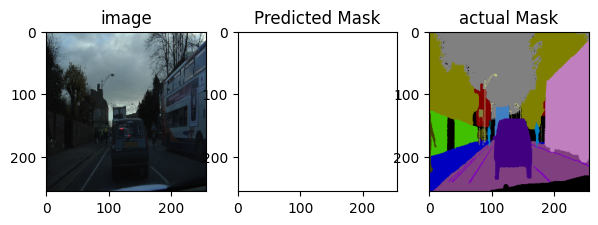

In [67]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

In [68]:
def show_result(og, pred, target):
    fig, axs = plt.subplots(1, 3, figsize=(10,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("Predict")
    axs[1].imshow(pred)
    axs[1].axis('off')
    
    axs[2].set_title("Target")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [71]:
loss, accuracy = u2net_model.evaluate(X_test, Y_test)

NameError: name 'Y_test' is not defined